# 第4章: 形態素解析

夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39はmatplotlibもしくはGnuplotを用いるとよい．

In [137]:
# $ mecab neko.txt > neko.txt.mecab
import MeCab
import numpy as np
import matplotlib.pyplot as plt

## 30. 形態素解析結果の読み込み
形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [37]:
with open('neko.txt.mecab', 'r', encoding='utf-8') as f:
    neko_mecab = f.readlines()

xstrip = lambda x: x.strip("\n")
is_not_eos = lambda x: x != "EOS"

neko_lines = list(filter(is_not_eos, map(xstrip, neko_mecab)))

def convert_nlpobj(line):
    surface, props = line.split("\t")
    pos, pos1, _, _, _, _, base, _, _ = (props.split(",") + [None, None])[:9]
    return {
        'surface': surface,
        'base': base,
        'pos': pos,
        'pos1': pos1 }
map_surface = lambda x: x['surface']
map_base = lambda x: x['base']
map_pos = lambda x: x['pos']
map_pos1 = lambda x: x['pos1']
neko_lib = list(map(convert_nlpobj, neko_lines))

## 31. 動詞
動詞の表層形をすべて抽出せよ．

In [38]:
verb_filter = lambda x: x['pos'] == '動詞'
verbs_surfaces = list(map(map_surface, filter(verb_filter, neko_lib)))
print(",".join(verbs_surfaces[:20]) + "...")

生れ,つか,し,泣い,し,いる,始め,見,聞く,捕え,煮,食う,思わ,載せ,られ,持ち上げ,られ,し,あっ,落ちつい...


## 32. 動詞の原形
動詞の原形をすべて抽出せよ．

In [39]:
verbs_bases = list(map(map_base, filter(verb_filter, neko_lib)))
print(",".join(verbs_bases[:20]) + "...")

生れる,つく,する,泣く,する,いる,始める,見る,聞く,捕える,煮る,食う,思う,載せる,られる,持ち上げる,られる,する,ある,落ちつく...


## 33. サ変名詞
サ変接続の名詞をすべて抽出せよ．

In [62]:
noun_filter = lambda x: x['pos'] == '名詞'
is_suru = lambda x:  x['base'] == 'する'
sahen_noun_filter = lambda x, nex: noun_filter(x) and is_suru(nex)

sahen_nouns = []
for i, x in enumerate(neko_lib):
    if i == 0:
        continue
    if sahen_noun_filter(neko_lib[i - 1], x):
        sahen_nouns.append(neko_lib[i - 1])
        
print(",".join(list(map(map_base, sahen_nouns[:20]))) + "...")

記憶,装飾,突起,咽,運転,記憶,我慢,餓死,訪問,遭遇,記憶,珍重,同居,観察,断言,同衾,尊敬,剿滅,憤慨,失敗...


## 34. 「AのB」
2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [67]:
nonoun_phrases = []
for i, x in enumerate(neko_lib):
    if x['base'] != 'の':
        continue
    pre, cur, nex = neko_lib[i - 1: i + 2]
    if not noun_filter(pre) or noun_filter(nex):
        continue
    nonoun_phrases.append(pre['surface'] + cur['surface'] + nex['surface'])
print(nonoun_phrases[:20])

['ものの見', '人間の飲む', '食物のある', '竹垣の崩れ', '下の黒い', '弾力のない', '天気のよい', '心持の好い', 'うちの小', '供のご', '吾輩の住み込ん', '後のある', '人のを', '詐りのない', '幅の大', '例のごとく', '猫のごとく', '漆のごとき', '方のない', '存分のし']


## 35. 名詞の連接
名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [95]:
long_noun = {}
chain = 0
term = ''
for i, x in enumerate(neko_lib):
    if noun_filter(x):
        chain += 1
        term += x['surface']
    else:
        if chain > 1:
            if chain not in long_noun:
                long_noun[chain] = []
            long_noun[chain].append(term)
            pass
        chain = 0
        term = ''
longest_nouns = long_noun[list(long_noun.keys())[-1]]
print(longest_nouns)

["manyaslip'twixtthecupandthelip", '明治三十八年何月何日戸締り']


## 36. 単語の出現頻度
文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [104]:
def ngram_map(words):
    gram = {}
    for word in words:
        if word not in gram:
            gram[word] = 0
        gram[word] += 1
    return gram

words = list(map(map_surface, neko_lib))
gram = ngram_map(words)
gram_ranks = list(sorted(gram.items(), key=lambda x: -x[1]))
for k, v in gram_ranks[:10]:
    print(k, v)

の 9194
。 7486
て 6868
、 6772
は 6420
に 6243
を 6071
と 5508
が 5337
た 3988


## 37. 頻度上位10語
出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

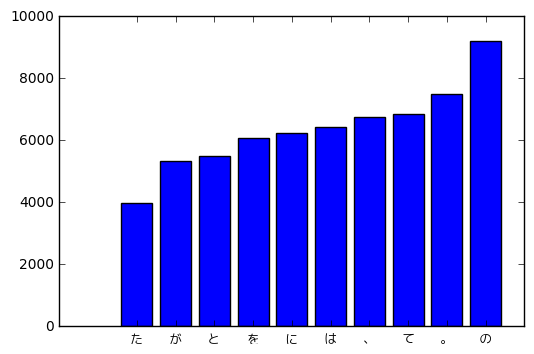

In [243]:
xy = np.array(list(reversed(gram_ranks[:10])))
X, Y = xy.T
fp = FontProperties(fname='/usr/local/Cellar/ricty/3.2.4/share/fonts/Ricty-Regular.ttf')
plt.bar(range(10), list(map(int, Y)), align='center')
plt.xticks(range(10), X, fontproperties=fp)
plt.show()

## 38. ヒストグラム
単語の出現頻度のヒストグラム（横軸に出現頻度，縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け．

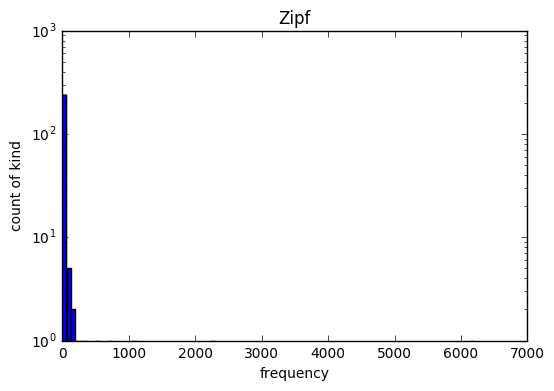

In [220]:
kind_counts = {}
for word, count in gram_ranks:
    if count not in kind_counts:
        kind_counts[count] = 0
    kind_counts[count] += 1

xy = np.array(list(sorted(kind_counts.items())))
X, Y = xy.T

plt.hist(list(map(int, Y)), bins=100)
plt.title("Zipf")
plt.xlabel("frequency")
plt.ylabel("count of kind")
plt.yscale('log')
plt.show()

## 39. Zipfの法則
単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

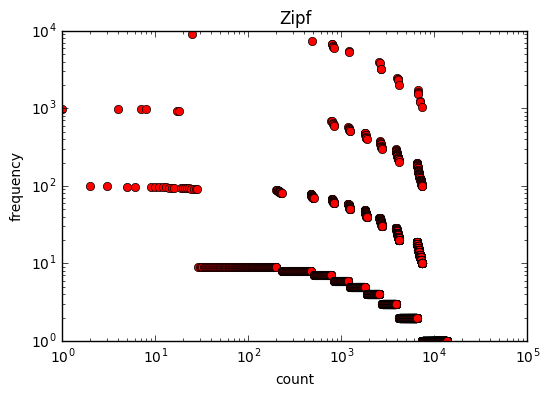

In [239]:
xy = np.array(gram_ranks)
_, Y = xy.T
plt.plot(range(len(Y)), list(reversed(sorted(Y))), 'ro')
plt.title("Zipf")
plt.xlabel("count")
plt.ylabel("frequency")
plt.xscale('log')
plt.yscale('log')
plt.show()